# 2. _Get a good model / Inspect model outputs_

In [1]:
from subgroups.dataloading_ffcv import make_dataloaders
from subgroups.resnet9 import construct_rn9

import numpy as np
import torch
import time

from tqdm.auto import tqdm
from torch.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
from torch.optim import Adam

from typing import List

from tqdm import tqdm

import matplotlib.pyplot as plt

/home/gridsan/djuna/.conda/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### - Make sure you trust your training code as a first step before integrating it into your main files

In [ ]:
def full_iteration_ffcv(train_dataset: str = None, test_dataset: str = None, batch_size: int = None, num_workers: int = None, 
                        seed: int = None, alpha: float = None, num_classes: int = None, lr: float = None, epochs: int = None, 
                        momentum: float = None, weight_decay: float = None, label_smoothing: float = None, 
                        length: int = None, get_val_samples: bool = None, no_transform: bool = None, set_seed: bool = None, return_sequential: bool = None, eval_test: bool = False) -> tuple:
    
    loaders, _ = make_dataloaders(
        train_dataset=train_dataset, test_dataset=test_dataset, batch_size=batch_size,
        num_workers=num_workers, seed=seed, alpha=alpha, length=length, get_val_samples=get_val_samples, no_transform=no_transform, return_sequential=return_sequential,
    )
    
    if set_seed:
        torch.manual_seed(42)           # Set seed for CPU RNG
        torch.cuda.manual_seed(42) 
        
    model = construct_rn9(num_classes=num_classes).to(memory_format=torch.channels_last).cuda()
    
    outs = train(
        model, loaders, lr=lr, epochs=epochs, momentum=momentum,
        weight_decay=weight_decay, label_smoothing=label_smoothing, eval_test=eval_test
    )
    param_values = f"""
    train_dataset: {train_dataset.split('/')[-1]}
    test_dataset: {test_dataset.split('/')[-1]}
    batch_size: {batch_size}
    train split seed: {seed}
    alpha: {alpha}
    lr: {lr}
    epochs: {epochs}
    momentum: {momentum}
    weight_decay: {weight_decay}
    label_smoothing: {label_smoothing}
    length: {length}
    no_transform: {no_transform}
    set_model_init_seed: {set_seed}
    return_train_sequential: {return_sequential}
    """
    outs['param_values'] = param_values

    return outs
    

def train(model: torch.nn.Module, loader: dict = None, lr: float = None, epochs: int = None, momentum: float = None,
          weight_decay: float = None, label_smoothing: float = None, eval_test: bool = None) -> dict:
    
    opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    scaler = GradScaler('cuda')
    
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    if not eval_test:
        out_loss = []
        out_acc = []
        out_labs = []
        out_pred = []

        model.train()  

        for ep in tqdm(range(epochs)):
            for it, (ims, labs) in enumerate(loader['train']):
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    out = model(ims)
                    loss = loss_fn(out, labs)
                    pred = out.argmax(1).eq(labs)
                    total_correct = pred.sum().cpu().item()
                    out_loss.append(loss.item())
                    out_acc.append(total_correct/ims.shape[0])
                    out_labs.append(labs)
                    out_pred.append(pred)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            
        return {
            'loss': out_loss,
            'accuracy': out_acc,
            'labels': out_labs,
            'predictions': out_pred
        }
    
    if eval_test:
        out_train_loss = []
        out_train_acc = []
        out_test_loss = []
        out_test_acc = []

        # do one evaluation before model training starts
        model.eval()
        with torch.no_grad():
            temp_loss = 0
            temp_acc = 0
            N = 0
            for it, (ims, labs) in enumerate(loader['test']):
                with autocast('cuda'):
                    out = model(ims)
                    loss = loss_fn(out, labs)
                    pred = out.argmax(1).eq(labs)
                    total_correct = pred.sum().cpu().item()
                    temp_loss+=loss.item()
                    temp_acc+=total_correct/ims.shape[0]
                    N+=1
            out_test_loss.append(temp_loss/N)
            out_test_acc.append(temp_acc/N)

        for ep in tqdm(range(epochs)):
            model.train()  
            for it, (ims, labs) in enumerate(loader['train']):
                opt.zero_grad(set_to_none=True)
                with autocast('cuda'):
                    out = model(ims)
                    loss = loss_fn(out, labs)
                    pred = out.argmax(1).eq(labs)
                    total_correct = pred.sum().cpu().item()
                    out_train_loss.append(loss.item())
                    out_train_acc.append(total_correct/ims.shape[0])
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()

            model.eval()
            with torch.no_grad():
                temp_loss = 0
                temp_acc = 0
                N = 0
                for it, (ims, labs) in enumerate(loader['test']):
                    with autocast('cuda'):
                        out = model(ims)
                        loss = loss_fn(out, labs)
                        pred = out.argmax(1).eq(labs)
                        total_correct = pred.sum().cpu().item()
                        temp_loss+=loss.item()
                        temp_acc+=total_correct/ims.shape[0]
                        N+=1
                out_test_loss.append(temp_loss/N)
                out_test_acc.append(temp_acc/N)
            
        return {
            'loss': out_train_loss,
            'accuracy': out_train_acc,
            'test_loss': out_test_loss,
            'test_accuracy': out_test_acc
        }



def plot_results(out, n_epoch, logscale=True, plot_test=False):
    data = out['loss']
    epoch_interval =  int(np.floor(len(data)/n_epoch))
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(len(data)), data, linewidth=0.1, label='train')
    if plot_test:
        data = out['test_loss']
        plt.plot([x*epoch_interval for x in np.arange(len(data))], data, linewidth=1, label='test')

    plt.ylabel('loss')
    plt.axhline(y=0.69, color='red', linestyle='--', linewidth=0.5, label='expected init loss')

    # Alternate fill with light red and even lighter red every 78 x-values to indicate an epoch
    data = out['loss']
    for i, epoch in enumerate(range(0, len(data),epoch_interval)):
        color = 'red' if i % 2 == 0 else 'lightblue'
        if i ==0:
            plt.axvspan(epoch, epoch + (epoch_interval), color=color, alpha=0.05, label='alternating epochs')
        else:
            plt.axvspan(epoch, epoch + (epoch_interval), color=color, alpha=0.05)
    plt.legend()
    if logscale:
        plt.yscale('log')
    else:
        plt.ylim(0,)

    data = out['accuracy']
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(len(data)), data, linewidth=0.1, label='train')

    if plot_test:
        data = out['test_accuracy']
        plt.plot([x*epoch_interval for x in np.arange(len(data))], data, linewidth=1, label='test')


    plt.axhline(y=0.6, color='red', linestyle='--', linewidth=0.5, label='chance')
    plt.xlabel('model update')
    plt.ylabel('accuracy')
    plt.ylim(0,)
    plt.legend()

    # Add param_values to the top right hand corner of the plot in a text box titled "parameters"
    param_values = out['param_values']
    plt.gca().text(0.95, 0.95, param_values, transform=plt.gca().transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))



### - Inspect your training loss curve first and compare it to chance (is the model learning?)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:33<00:00,  2.15it/s]


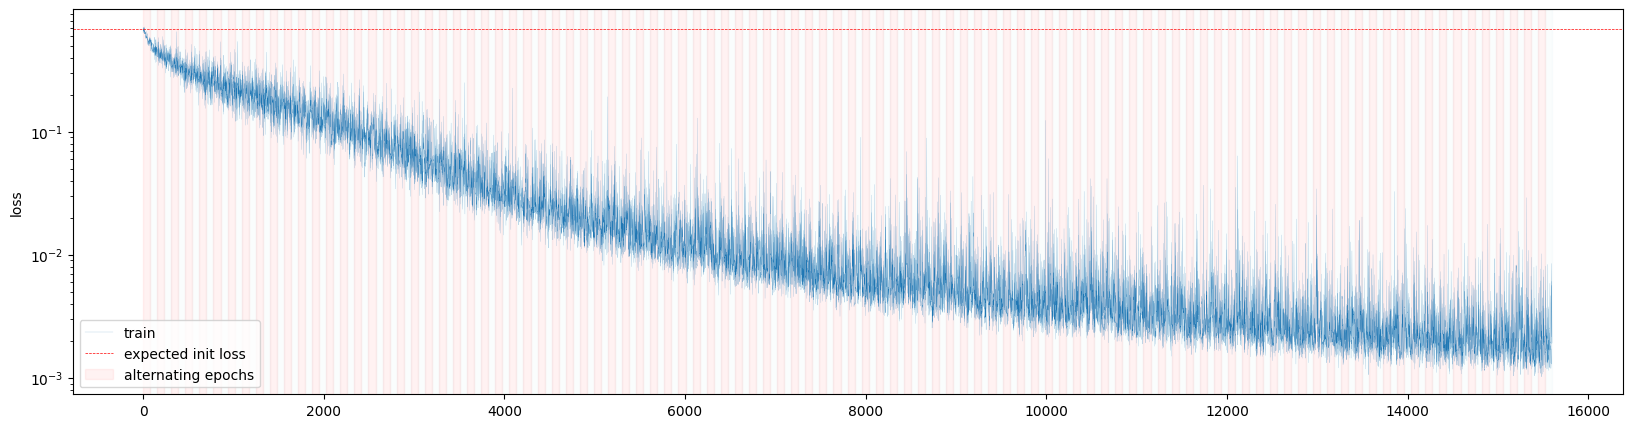

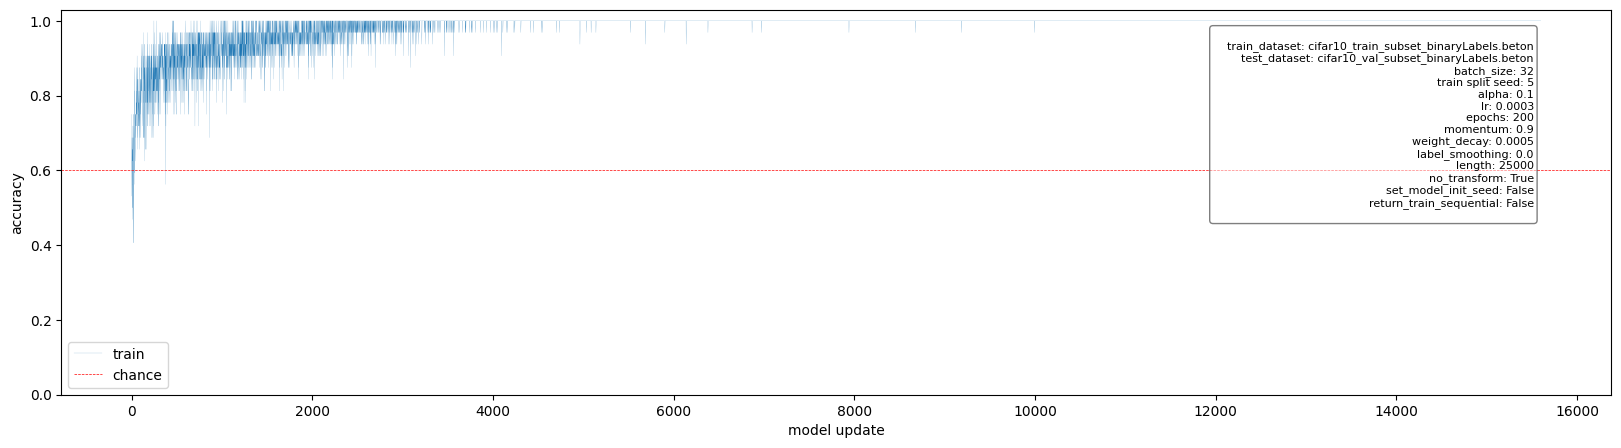

In [4]:
# get data
train_dataset = './CIFAR10/cifar10_train_subset_binaryLabels.beton'
test_dataset = './CIFAR10/cifar10_val_subset_binaryLabels.beton'


out = full_iteration_ffcv(train_dataset, test_dataset, batch_size=32, num_workers=1, 
                                seed=5, alpha=0.1, num_classes=2, lr=3e-4, epochs=200, 
                                momentum=0.9, weight_decay=5e-4, label_smoothing=0.0, 
                                length=25000, get_val_samples=False, no_transform=True, set_seed = False, return_sequential=False) 

plot_results(out, 200)

### - Now what happens when you plot the validation loss? Does it look reasonable?

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:59<00:00,  1.67it/s]


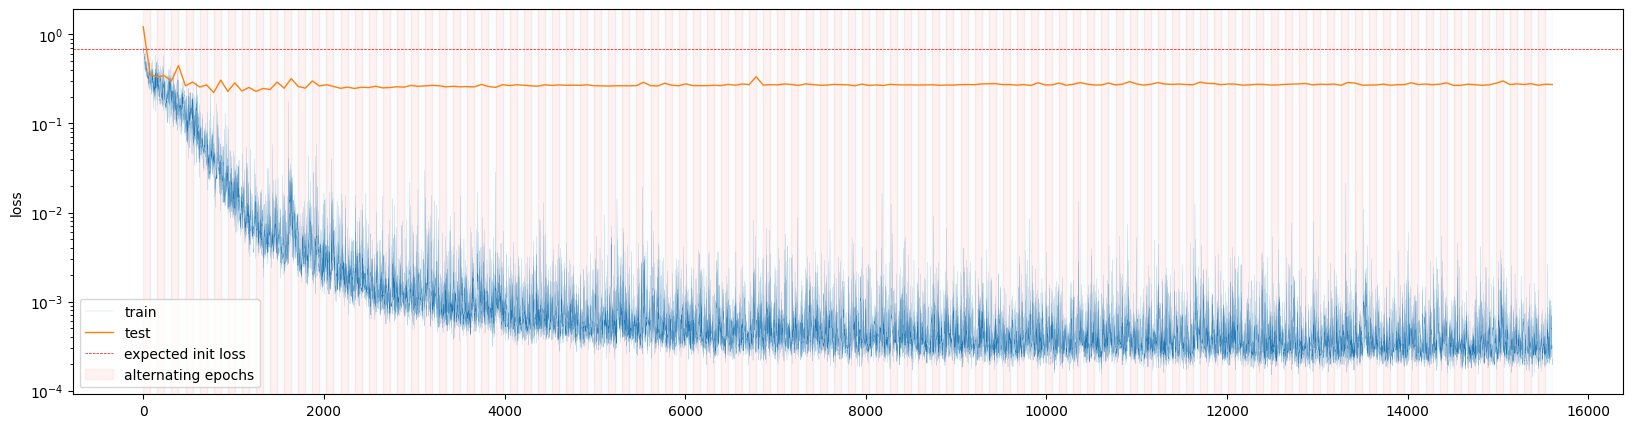

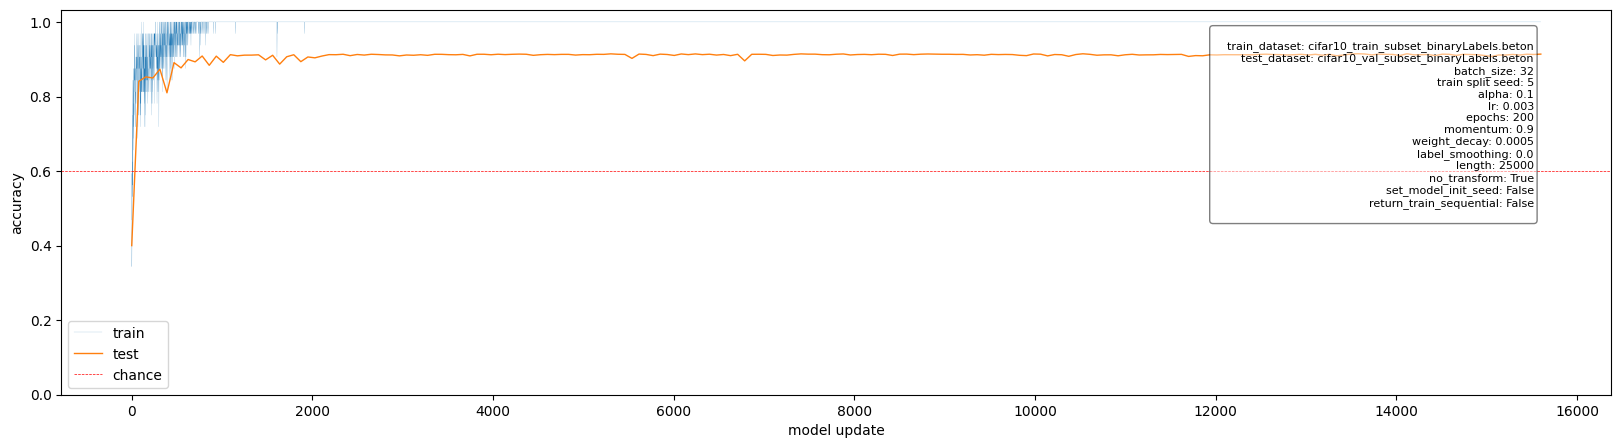

In [5]:
# get data
train_dataset = './CIFAR10/cifar10_train_subset_binaryLabels.beton'
test_dataset = './CIFAR10/cifar10_val_subset_binaryLabels.beton'


out = full_iteration_ffcv(train_dataset, test_dataset, batch_size=32, num_workers=1, 
                                seed=5, alpha=0.1, num_classes=2, lr=3e-3, epochs=200, 
                                momentum=0.9, weight_decay=5e-4, label_smoothing=0.0, 
                                length=25000, get_val_samples=False, no_transform=True, set_seed = False, return_sequential=False, eval_test=True) 

plot_results(out, 200, plot_test=True)

### - What's your test accuracy so far?

In [6]:
np.max(out['test_accuracy'])

np.float64(0.9147364217252396)

### - How variable is the loss to model initiation?

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.60it/s]


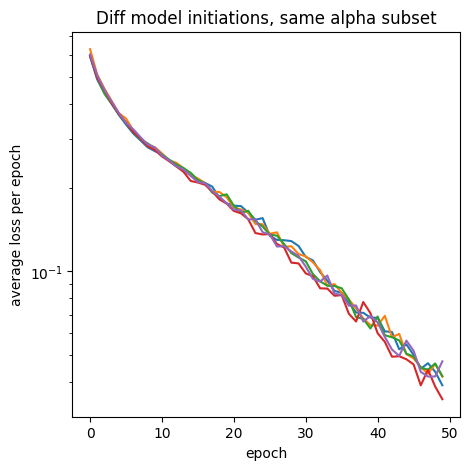

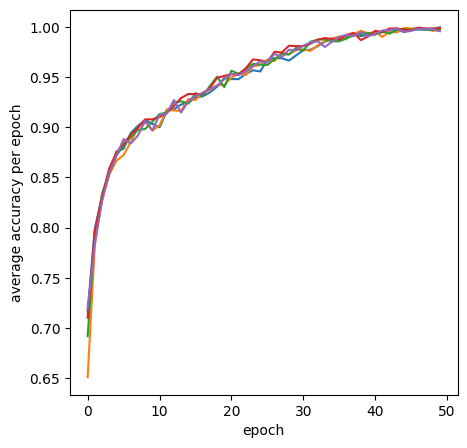

In [8]:
model_diff_inits = []
for i in range(5):
    out = full_iteration_ffcv(train_dataset, test_dataset, batch_size=32, num_workers=1, 
                                    seed=5, alpha=0.1, num_classes=2, lr=3e-4, epochs=50, 
                                    momentum=0.9, weight_decay=5e-4, label_smoothing=0.0, 
                                    length=25000, get_val_samples=False, no_transform=True, set_seed = False, return_sequential=False) 
    model_diff_inits.append(out)

plt.figure(figsize=(5,5))
for out in model_diff_inits:
    avg_loss = [np.mean(out['loss'][i:i + int(np.floor(2500/32))]) for i in range(0, len(out['loss']), int(np.floor(2500/32)))]
    plt.plot(range(50), avg_loss)
    plt.xlabel('epoch')
    plt.ylabel('average loss per epoch')
plt.yscale('log')
plt.title('Diff model initiations, same alpha subset')
plt.figure(figsize=(5,5))
for out in model_diff_inits:
    avg_loss = [np.mean(out['accuracy'][i:i + int(np.floor(2500/32))]) for i in range(0, len(out['accuracy']), int(np.floor(2500/32)))]
    plt.plot(range(50), avg_loss)
    plt.xlabel('epoch')
    plt.ylabel('average accuracy per epoch')
